In [1]:
import warnings
from typing import Union

# Data Analysis
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Evaluating and preprocessing
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.inspection import permutation_importance

# Modeling
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# 1. Data and Problem Overview

In [2]:
df = pd.read_csv('/kaggle/input/obesity-levels/ObesityDataSet_raw_and_data_sinthetic.csv')
df.head()

,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [3]:
df['CALC'].unique()

array(['no', 'Sometimes', 'Frequently', 'Always'], dtype=object)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

# 2. EDA Analysis

In [5]:
df.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


## 2.1 Distribution Analysis

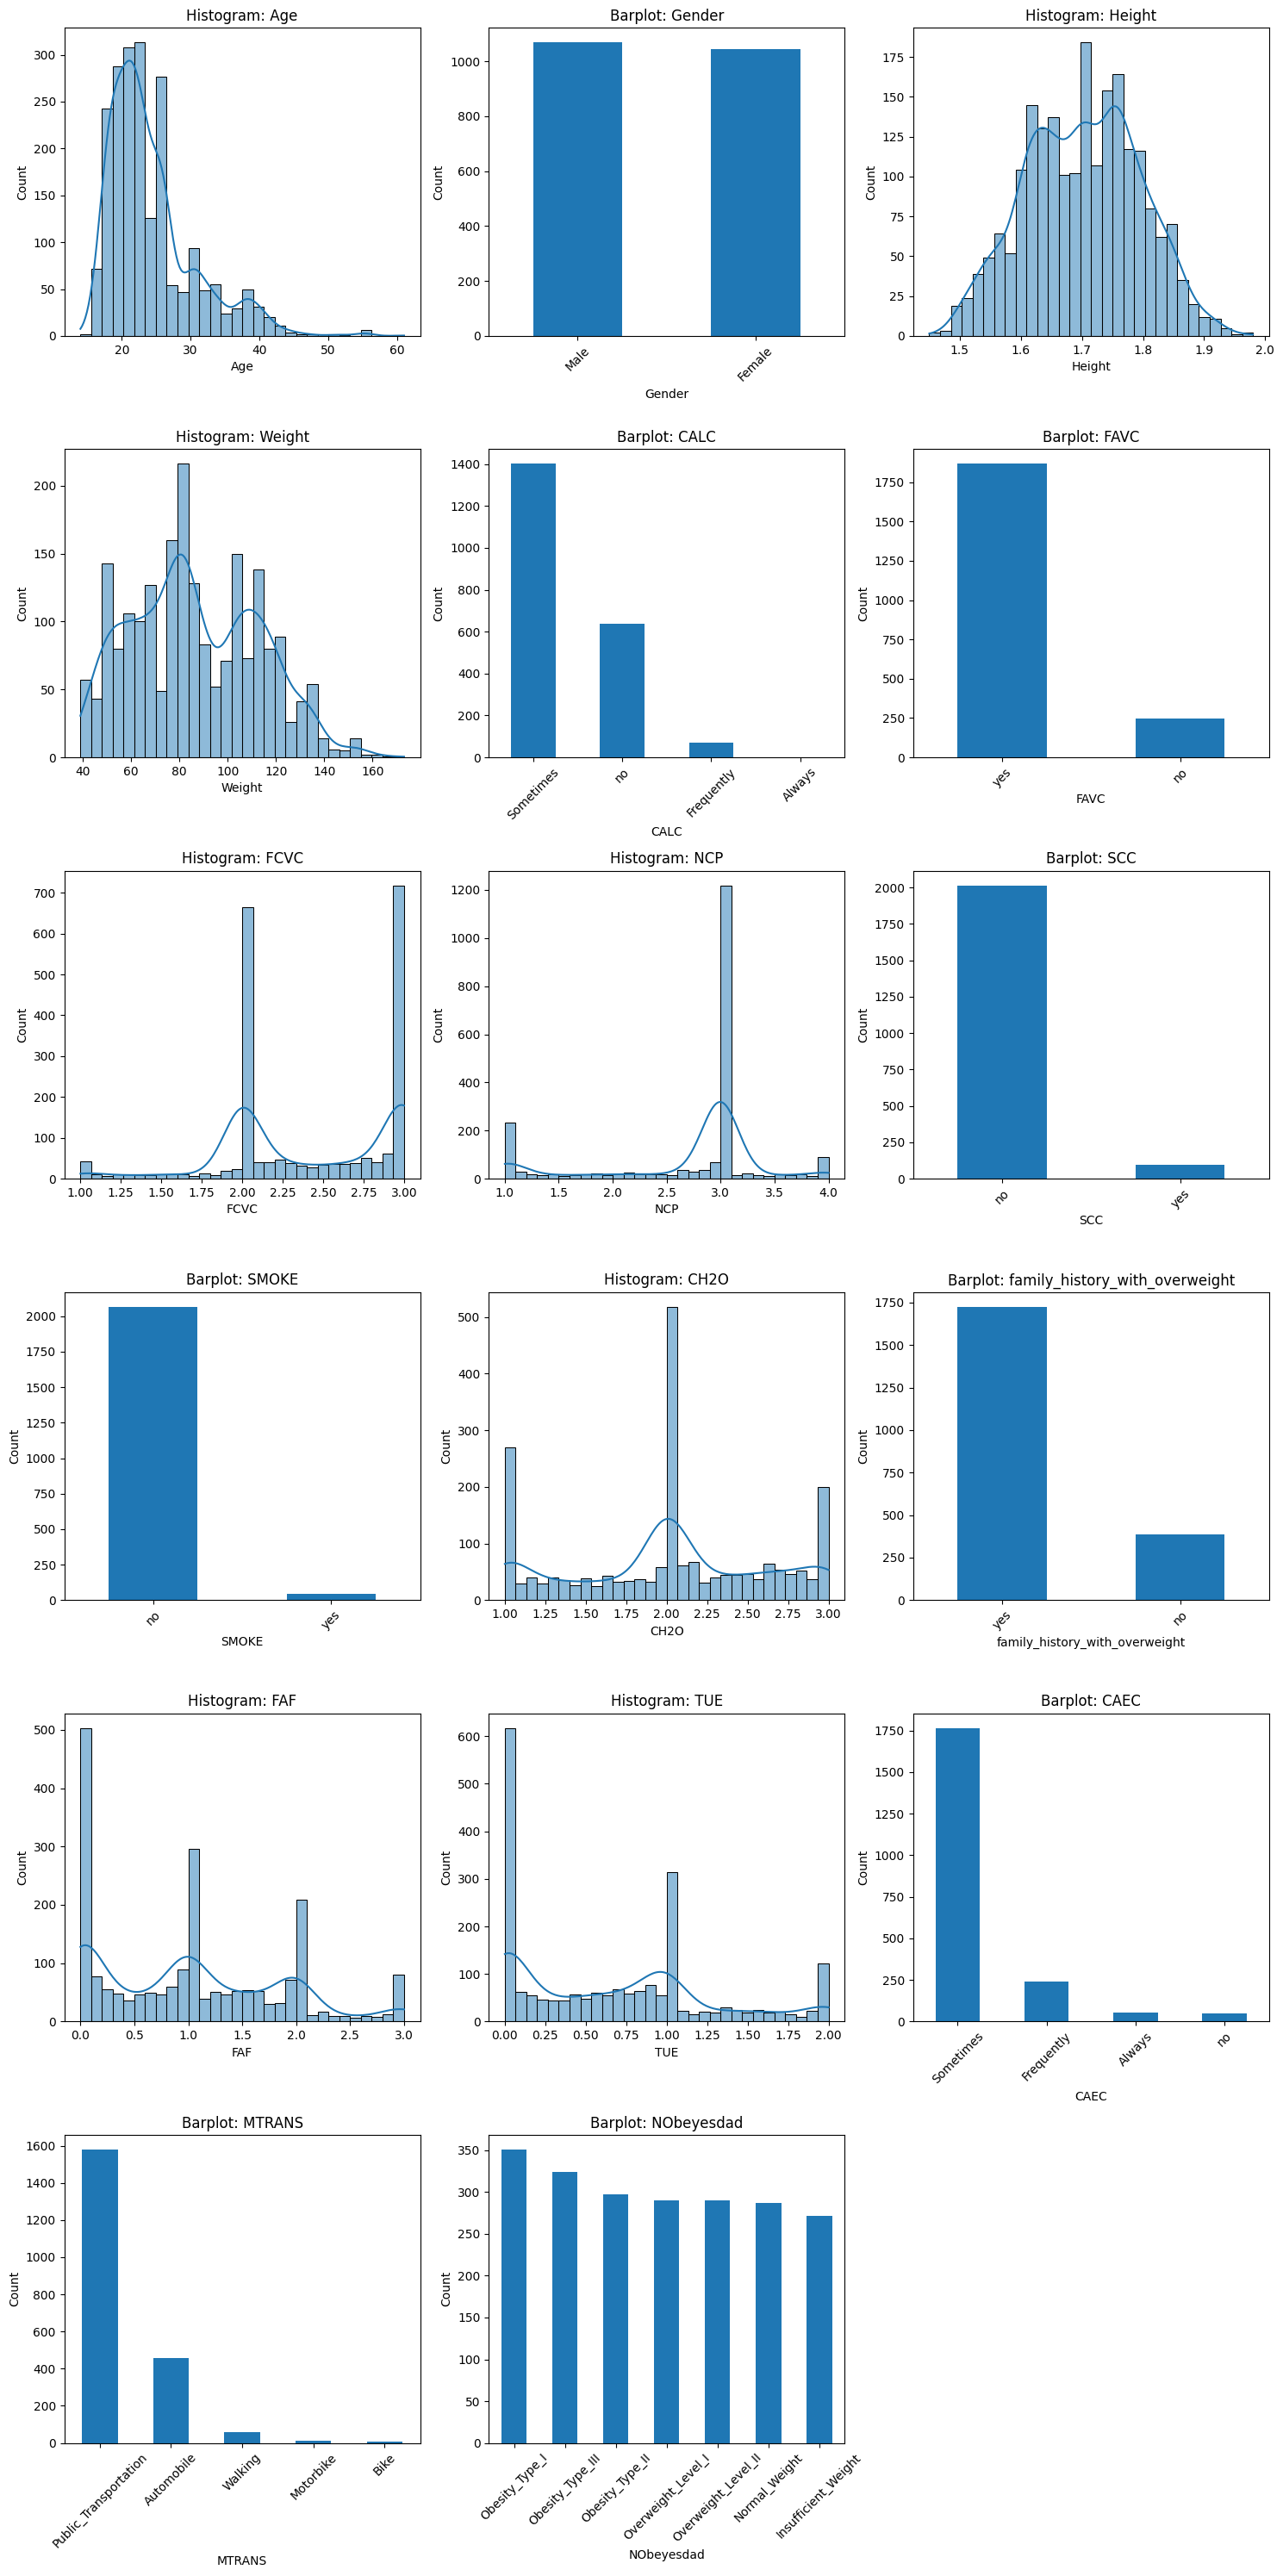

In [6]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Define grid size
    n_cols = 3
    n_rows = (len(df.columns) + n_cols - 1) // n_cols
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = axes.flatten()
    
    # Iterate through columns
    for i, column in enumerate(df.columns):
        ax = axes[i]
        if df[column].dtype in ['float64', 'int64']:
            # Histogram for numerical columns
            sns.histplot(df[column], kde=True, ax=ax, bins=30)
            ax.set_title(f'Histogram: {column}')
        else:
            # Bar plot for categorical columns
            df[column].value_counts().plot(kind='bar', ax=ax)
            ax.set_title(f'Barplot: {column}')
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
            ax.set_ylabel('Count')
    
    # Remove empty subplots, if any
    for j in range(len(df.columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

**Activity and Lifestyle**

- Physical activity levels (**FAF**) are **low**, with most individuals showing minimal activity.  
- The most common mode of transportation is **public transportation**, followed by automobiles.  
- **Smoking** is rare among the group, indicating overall low engagement in harmful lifestyle habits.  
- Time spent on **technology devices** (**TUE**) varies, but a significant portion of individuals spends minimal to moderate time on such devices.

---

**Dietary Habits**

- Most individuals eat **3 meals a day**, which aligns with healthy eating guidelines.  
- Regular consumption of **vegetables** (**FCVC**) is observed, with values clustered around the higher end of the scale.  
- However, **calorie intake between meals** (**CAEC**) is **frequent**, with "Sometimes" being the dominant category, which may contribute to excess calorie consumption.  
- **Calorie monitoring** (**SCC**) is rare, indicating a lack of attention to daily energy intake.

---

**Genetic Factors**

- A majority of individuals have a **family history of overweight**, suggesting that **genetic predisposition** plays a significant role in the observed trends.  
- This correlation highlights the importance of combining genetic factors with lifestyle interventions to manage weight effectively.

---

**Obesity**

- The distribution of obesity levels is relatively balanced in this sample, which provides a solid foundation for building an effective classifier.

---

**Key Observations**

1. *Physical Inactivity*:  
   The combination of low physical activity levels and reliance on public transportation suggests limited movement outside daily commuting.

2. *Dietary Imbalances*:  
   While vegetable consumption is regular, frequent eating between meals and a lack of calorie monitoring could explain the prevalence of obesity.

3. *Genetic Impact*:  
   The strong genetic predisposition toward overweight highlights a need for targeted strategies that address both hereditary and behavioral factors.

4. *Obesity Trends*:  
   The dominance of **Obesity_Type_I** and other obesity levels indicates a concerning trend, requiring interventions in diet, activity, and awareness.

---

**Conclusions from distributions**

The data reveals a **multifaceted relationship** between lifestyle, dietary habits, genetic predisposition, and obesity. While there are some positive indicators, such as vegetable consumption and low smoking rates, challenges like **low physical activity**, **calorie intake between meals**, and **genetic factors** contribute to the observed obesity levels.re also observed.

## 2.2 Outlier Analysis

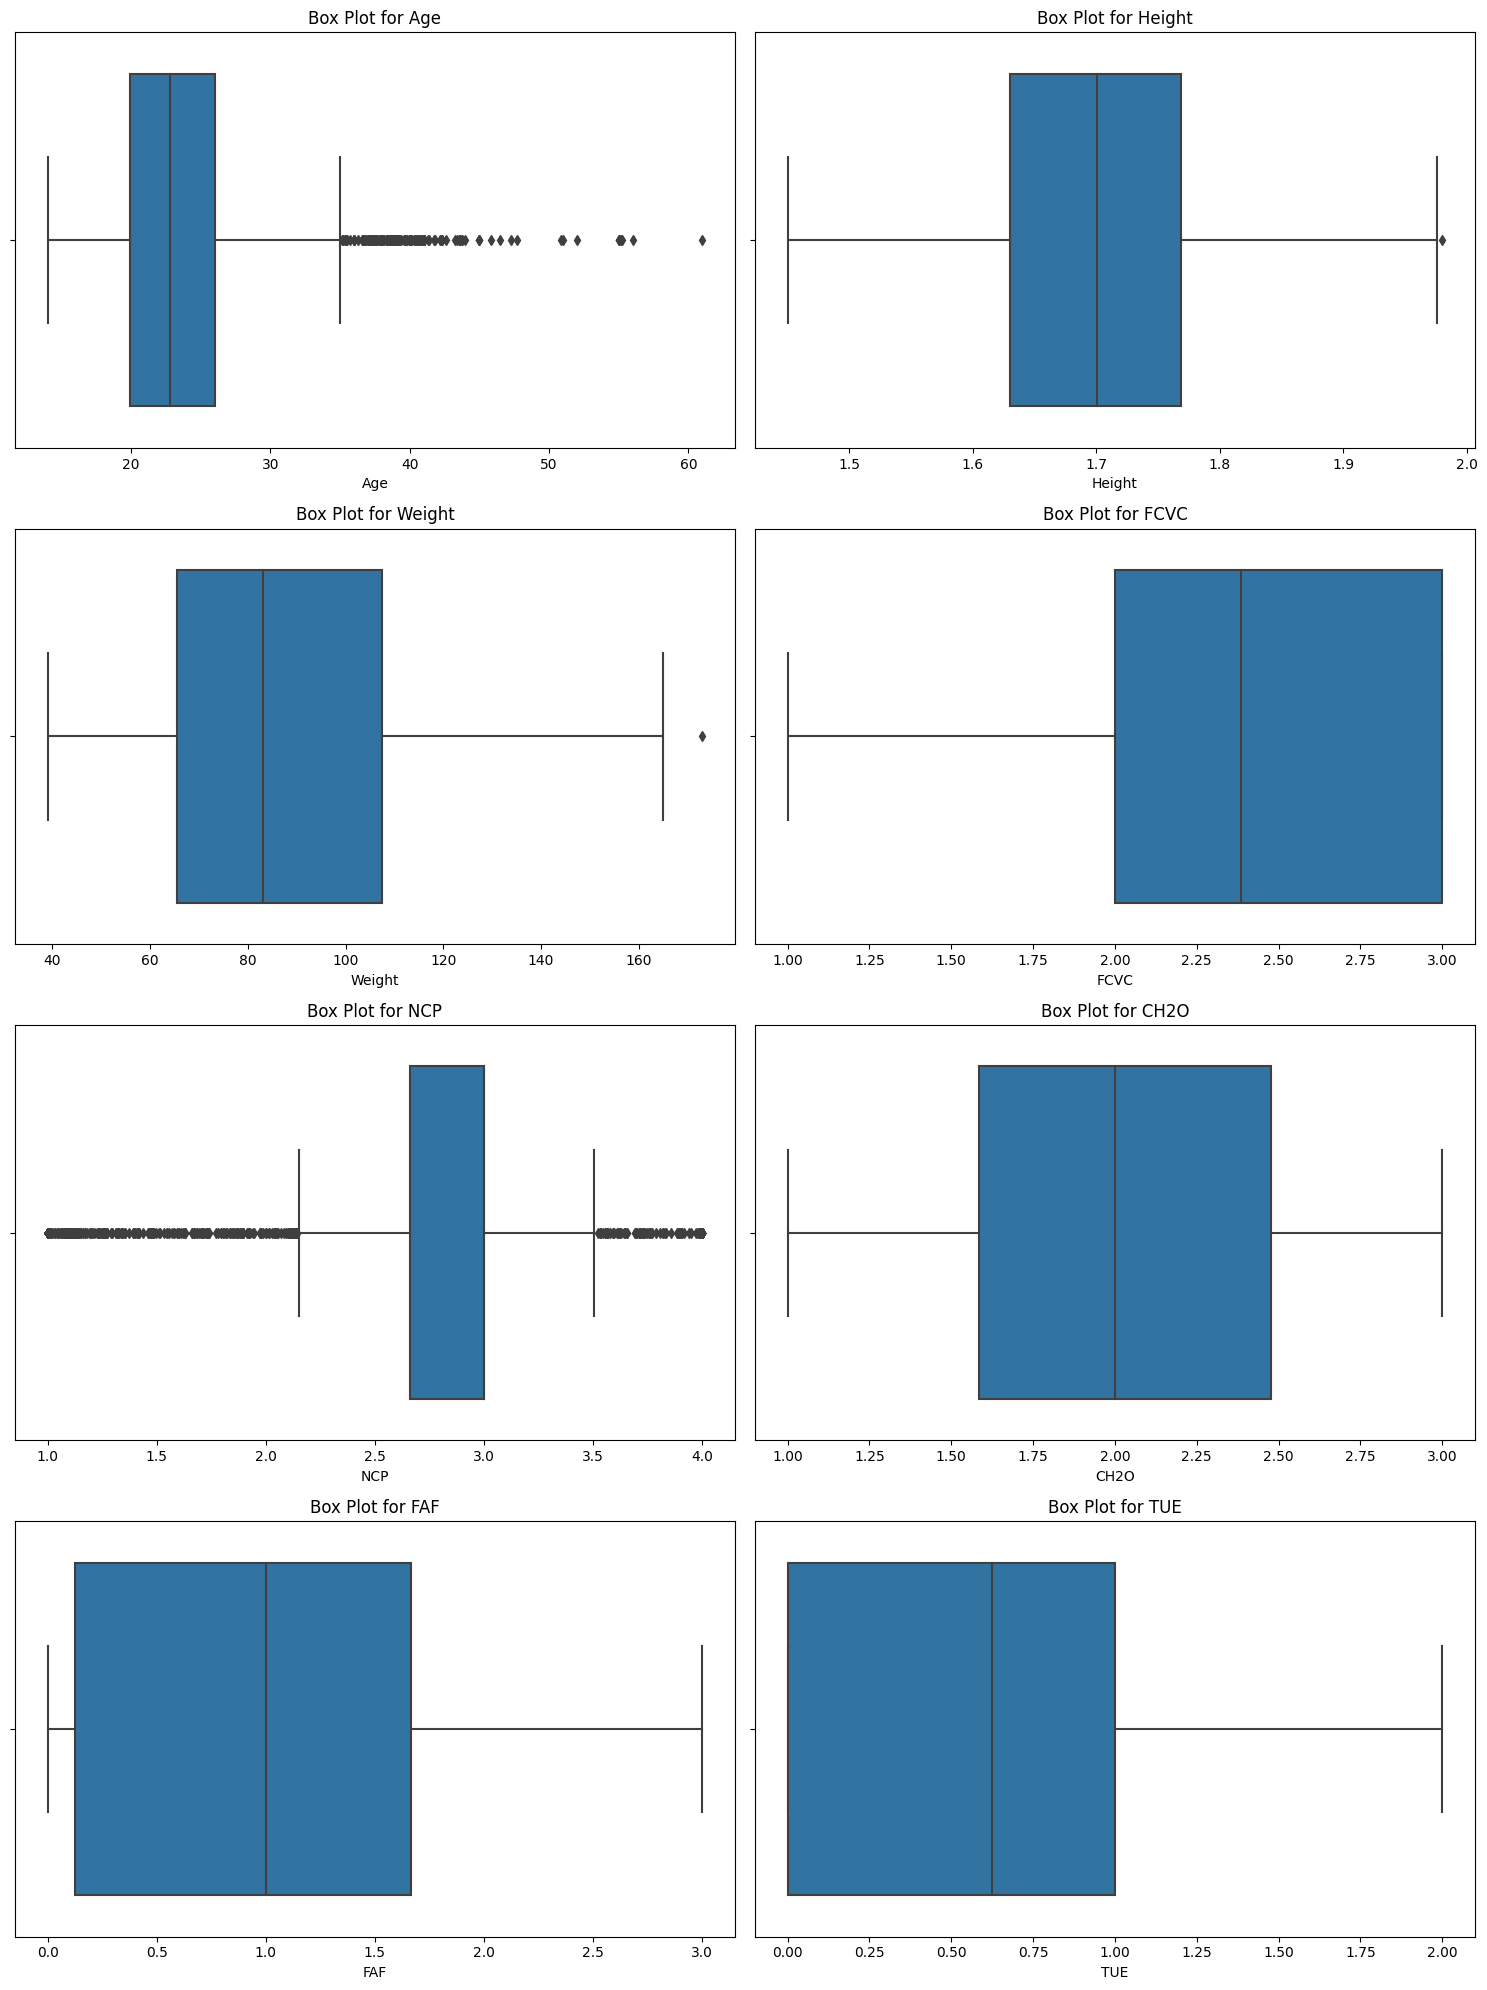

In [7]:
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(15, 5 * n_rows))
for i, column in enumerate(numerical_columns, start=1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(data=df, x=column)
    plt.title(f'Box Plot for {column}')

plt.tight_layout()

## 2.3 Duplicates Analysis

In [8]:
num_duplicates = df.duplicated().sum()
print(f"Number of duplicates in the dataset: {num_duplicates}")

Number of duplicates in the dataset: 24


# 3. Feature Engineering

In [9]:
# Calculates Body Mass Index (BMI) based on weight and height.
df['BMI'] = df['Weight'] / (df['Height'] ** 2)

# Estimates the number of meals per day by combining vegetable frequency and main meal count.
df['Meals_Per_Day'] = df['FCVC'] + df['NCP']

# Determines the ratio of vegetable-based meals to total main meals.
df['Vegetable_Meal_Ratio'] = df['FCVC'] / (df['NCP'] + 1)

# Computes total activity score as the product of activity frequency and exercise duration.
df['Total_Activity_Score'] = df['FAF'] * df['TUE']

# Categorizes age into "Young," "Adult," and "Elderly" groups based on defined age ranges.
df['Age_Category'] = pd.cut(df['Age'], bins=[0, 18, 60, float('inf')], labels=['Young', 'Adult', 'Elderly'])

# Calculates daily water intake per kilogram of body weight.
df['Water_Intake_Per_Kg'] = df['CH2O'] / df['Weight']

# Normalizes physical activity frequency by adjusting for BMI.
df['Normalized_Activity'] = df['FAF'] / (df['BMI'] + 1)

# Identifies stress indicators based on low activity frequency and high exercise duration.
df['Stress_Indicator'] = (df['FAF'] < 1) & (df['TUE'] >= 1.5)

# 4. Data Processing

## 4.1 Drop duplicates

In [10]:
df.drop_duplicates(inplace=True)

In [11]:
# copy orginal BMI values for BIM model
df_bmi = pd.DataFrame(df['BMI'].copy())

In [12]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

## 4.3 Encoding categorical variables

In [13]:
# Label Encoding
label_columns = ["Gender", "FAVC", "SCC", "SMOKE", "family_history_with_overweight"]
for col in label_columns:
    encoder = LabelEncoder()
    df[col] = encoder.fit_transform(df[col])

# One-Hot Encoding
one_hot_columns = ["MTRANS", "CAEC"]
df = pd.get_dummies(df, columns=one_hot_columns, drop_first=True)  # Drop_first to avoid multicollinearity

# Ordinal Encoding
ordinal_map = {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3}
df["CALC_ordinal"] = df["CALC"].map(ordinal_map)
df.drop(columns=["CALC"], inplace=True)

# Map each category to a numerical value
age_category_mapping = {'Young': 0, 'Adult': 1, 'Elderly': 2}

# Apply the mapping
df['Age_Category_Encoded'] = df['Age_Category'].map(age_category_mapping).astype(int)
df.drop(columns=["Age_Category"], inplace=True)

encoding_obesity_map = {
    'Insufficient_Weight': 0,
    'Normal_Weight': 1,
    'Overweight_Level_I': 2,
    'Overweight_Level_II': 3,
    'Obesity_Type_I': 4,
    'Obesity_Type_II': 5,
    'Obesity_Type_III': 6
}

df['NObeyesdad_encoded'] = df['NObeyesdad'].map(encoding_obesity_map)
df.drop(columns=["NObeyesdad"], inplace=True)

df_bmi['NObeyesdad_encoded'] = df['NObeyesdad_encoded'].copy()

In [14]:
reverse_encoding_obesity_map = {v: k for k, v in encoding_obesity_map.items()}

## 4.2 Scaling

In [15]:
# Initialize the scaler
scaler = RobustScaler()

# Apply the scaler to numerical columns
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

In [16]:
# Convert all boolean columns to integers
bool_columns = df.select_dtypes(include='bool').columns
df[bool_columns] = df[bool_columns].astype(int)

## 4.4 Downcasting

In [17]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print('Memory usage decreased from {:5.2f} Mb to {:5.2f} Mb ({:.1f}% reduction)'
              .format(start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [18]:
df = reduce_mem_usage(df)

Memory usage decreased from  0.49 Mb to  0.16 Mb (67.7% reduction)


# 5. Modeling

## 5.1 Correlation

### 5.1.1 Pearson

<Axes: >

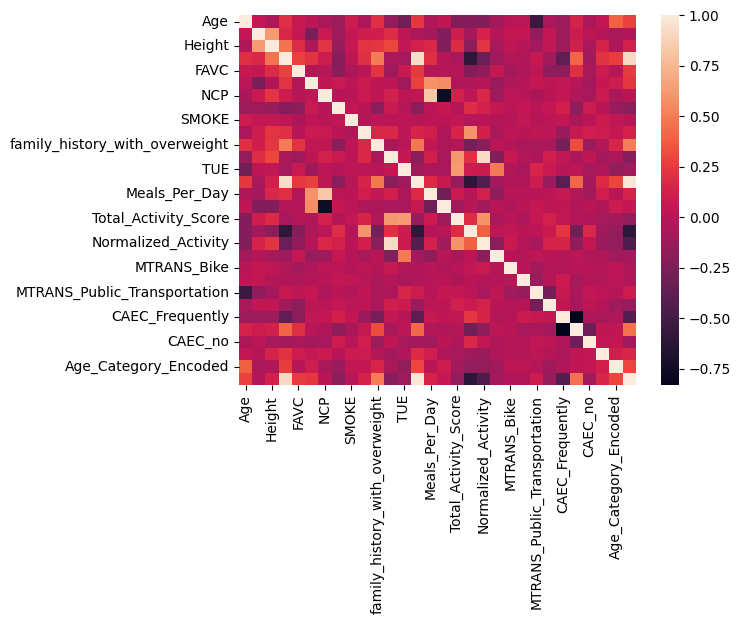

In [19]:
pearson_corr = df.corr(method='pearson')
sns.heatmap(pearson_corr)

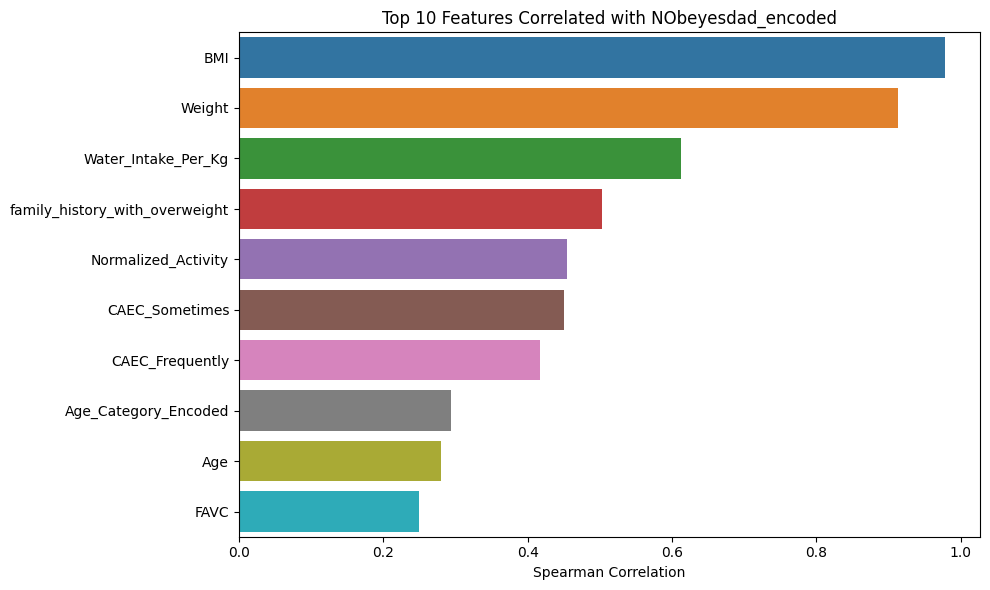

In [20]:
# Select correlations for the variable 'NObeyesdad_encoded'
nobeyesdad_corr = pearson_corr["NObeyesdad_encoded"].drop("NObeyesdad_encoded")  # Remove self-correlation (1.0)

# Sort variables by the absolute values of their correlations
top_10_corr = nobeyesdad_corr.abs().sort_values(ascending=False).head(10)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index)
plt.xlabel("Spearman Correlation")
plt.title("Top 10 Features Correlated with NObeyesdad_encoded")
plt.tight_layout()

### 5.1.2 Spearman

<Axes: >

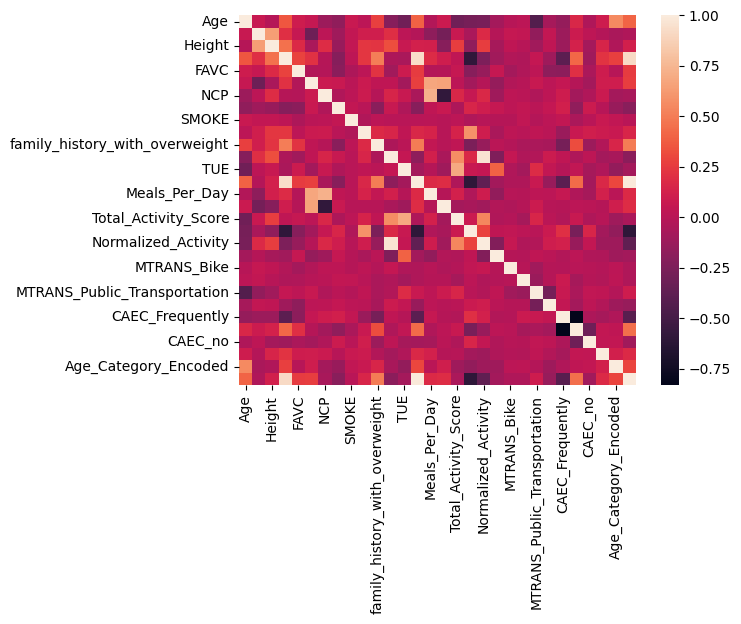

In [21]:
spearman_corr = df.corr(method='spearman')
sns.heatmap(spearman_corr)

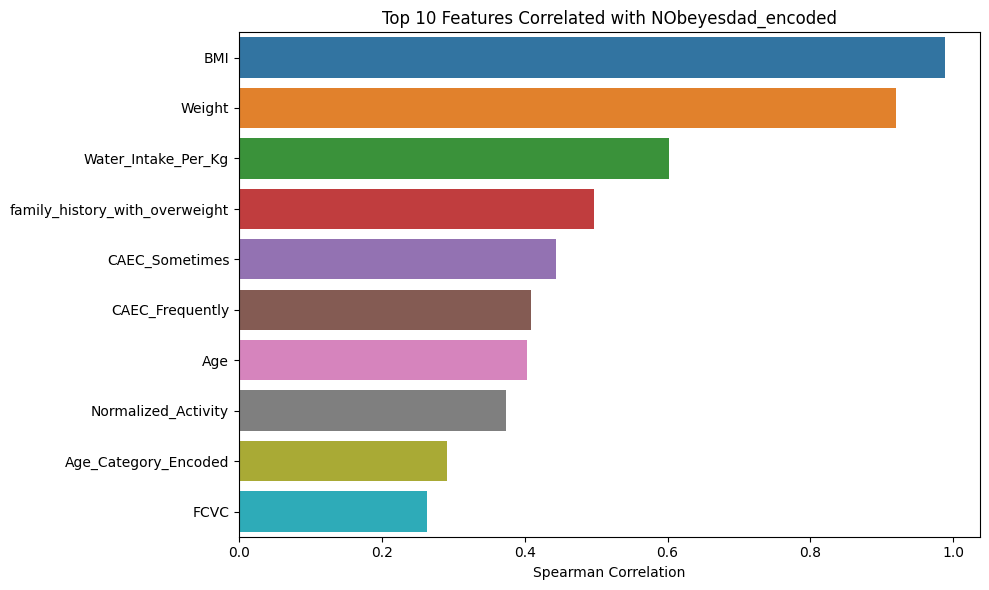

In [22]:
# Select correlations for the variable 'NObeyesdad_encoded'
nobeyesdad_corr = spearman_corr["NObeyesdad_encoded"].drop("NObeyesdad_encoded")  # Remove self-correlation (1.0)

# Sort variables by the absolute values of their correlations
top_10_corr = nobeyesdad_corr.abs().sort_values(ascending=False).head(10)

# Create the plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_corr.values, y=top_10_corr.index)
plt.xlabel("Spearman Correlation")
plt.title("Top 10 Features Correlated with NObeyesdad_encoded")
plt.tight_layout()

## 5.2 Split data

In [23]:
X = df.drop(columns=["NObeyesdad_encoded"])

y = df["NObeyesdad_encoded"]

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1920)

In [25]:
X_bmi = df.drop(columns=["NObeyesdad_encoded"])
X_bmi["BMI"] = df_bmi["BMI"]
y_bmi = df_bmi["NObeyesdad_encoded"]

In [26]:
X_train_bmi, X_test_bmi, y_train_bmi, y_test_bmi = train_test_split(X_bmi, y_bmi, test_size=0.3, random_state=1920)

In [27]:
y_test_bmi = y_test_bmi.astype('int8')
pd.testing.assert_series_equal(y_test, y_test_bmi)

## 5.3 Baseline model

In [28]:
class BMIObesityClassifier(BaseEstimator, ClassifierMixin):
    """Custom Obesity Classifier compatible with Sklearn API"""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        """This model does not require fitting as it is rule-based"""
        return self

    def classify_bmi(self, bmi: Union[int, float]) -> int:
        if bmi < 18.5:
            return 0
        elif 18.5 <= bmi < 24.9:
            return 1
        elif 25 <= bmi < 29.9:
            return 2
        elif 30 <= bmi < 34.9:
            return 3
        elif 35 <= bmi < 39.9:
            return 4
        elif 40 <= bmi < 49.9:
            return 5
        else:
            return 6
            
    def predict(self, X: Union[pd.DataFrame, pd.Series, dict]) -> pd.Series:
        y_pred = X['BMI'].apply(self.classify_bmi)
        return y_pred

In [29]:
clf = BMIObesityClassifier()
y_pred_bmi = clf.predict(X_test_bmi)

In [30]:
bmi_report = classification_report(y_test_bmi, y_pred_bmi)
print(bmi_report)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        86
           1       0.96      1.00      0.98        92
           2       0.45      0.96      0.62        72
           3       0.02      0.02      0.02        87
           4       0.00      0.00      0.00       112
           5       0.00      0.00      0.00        81
           6       0.25      0.01      0.02        97

    accuracy                           0.40       627
   macro avg       0.38      0.43      0.38       627
weighted avg       0.37      0.40      0.36       627



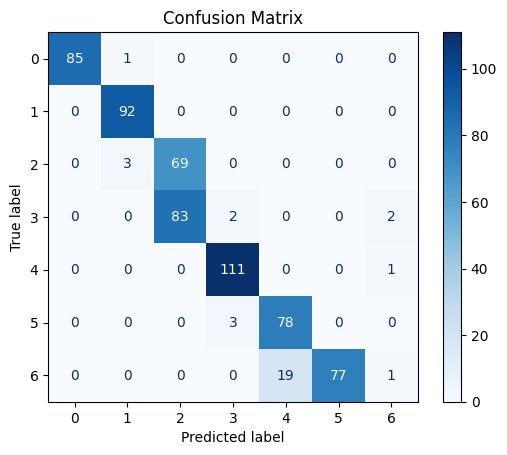

In [31]:
# Generate the confusion matrix
cm = confusion_matrix(y_test_bmi, y_pred_bmi)
pd.DataFrame(cm).to_csv("confusion_matrix_bmi_model.csv", index=False, header=False)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test_bmi.unique()))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## 5.4 Random Forest

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        86
           1       0.93      1.00      0.96        92
           2       0.97      0.94      0.96        72
           3       1.00      0.95      0.98        87
           4       0.99      1.00      1.00       112
           5       1.00      1.00      1.00        81
           6       1.00      1.00      1.00        97

    accuracy                           0.98       627
   macro avg       0.98      0.98      0.98       627
weighted avg       0.98      0.98      0.98       627



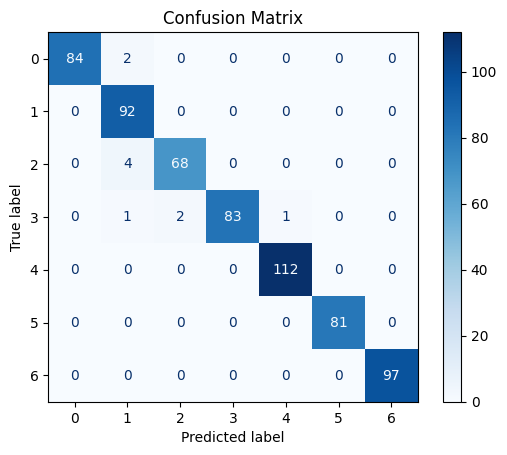

In [32]:
# Random Forest Classifier

rf_model = RandomForestClassifier(random_state=42)

rf_model.fit(X_train, y_train)

rf_predictions = rf_model.predict(X_test)

# Evaluation

rf_report = classification_report(y_test, rf_predictions)
print(rf_report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)
pd.DataFrame(cm).to_csv("confusion_matrix_rf.csv", index=False, header=False)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## 5.5 XGBoost Classifier

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        86
           1       0.97      1.00      0.98        92
           2       0.96      0.94      0.95        72
           3       0.99      0.94      0.96        87
           4       0.98      1.00      0.99       112
           5       1.00      0.99      0.99        81
           6       0.99      1.00      0.99        97

    accuracy                           0.98       627
   macro avg       0.98      0.98      0.98       627
weighted avg       0.98      0.98      0.98       627



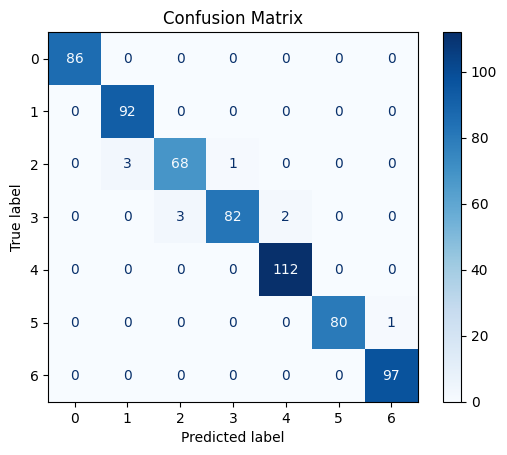

In [33]:
# XGBoost Classifier

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

xgb_predictions = xgb_model.predict(X_test)

# Evaluation

xgb_report = classification_report(y_test, xgb_predictions)
print(xgb_report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)
pd.DataFrame(cm).to_csv("confusion_matrix_xgb.csv", index=False, header=False)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

## 5.6 Logistic Regression

              precision    recall  f1-score   support

           0       0.88      0.98      0.92        86
           1       0.85      0.76      0.80        92
           2       0.79      0.75      0.77        72
           3       0.77      0.83      0.80        87
           4       0.97      0.88      0.92       112
           5       0.89      0.99      0.94        81
           6       1.00      1.00      1.00        97

    accuracy                           0.89       627
   macro avg       0.88      0.88      0.88       627
weighted avg       0.89      0.89      0.88       627



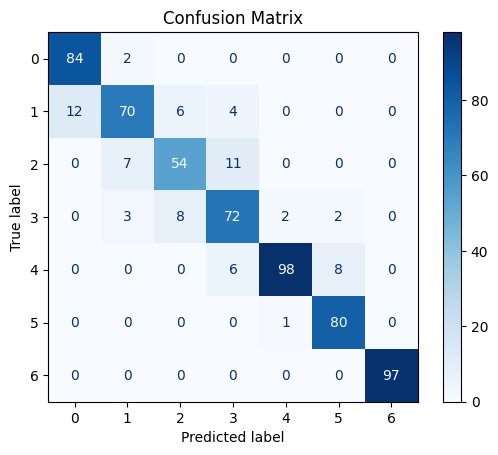

In [34]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

y_pred_log_reg = logreg.predict(X_test)

# Evaluation
report = classification_report(y_test, y_pred_log_reg)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_log_reg)
pd.DataFrame(cm).to_csv("confusion_matrix_logreg.csv", index=False, header=False)
# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=logreg.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [35]:
models = {
    "BIM_Modle": y_pred_bmi, 
    "RandomForest": rf_predictions, 
    "XGBoost": xgb_predictions, 
    "LogisticRegression": y_pred_log_reg
}

reports = []

for model_name, y_pred in models.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    
    report_df = pd.DataFrame(report).transpose()
    
    report_df["Model"] = model_name
    
    reports.append(report_df)

final_report_df = pd.concat(reports)

final_report_df.to_csv("classification_reports.csv", index=True)

# 6. Explaining Models and Analysis of Feature Significance in Obesity

## 6.1 Permutation Importance

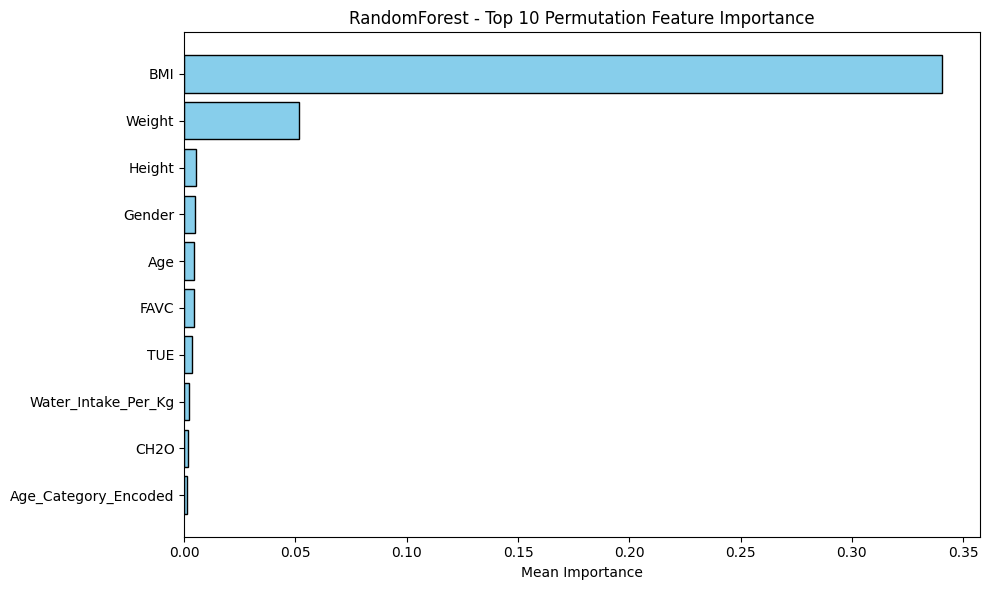

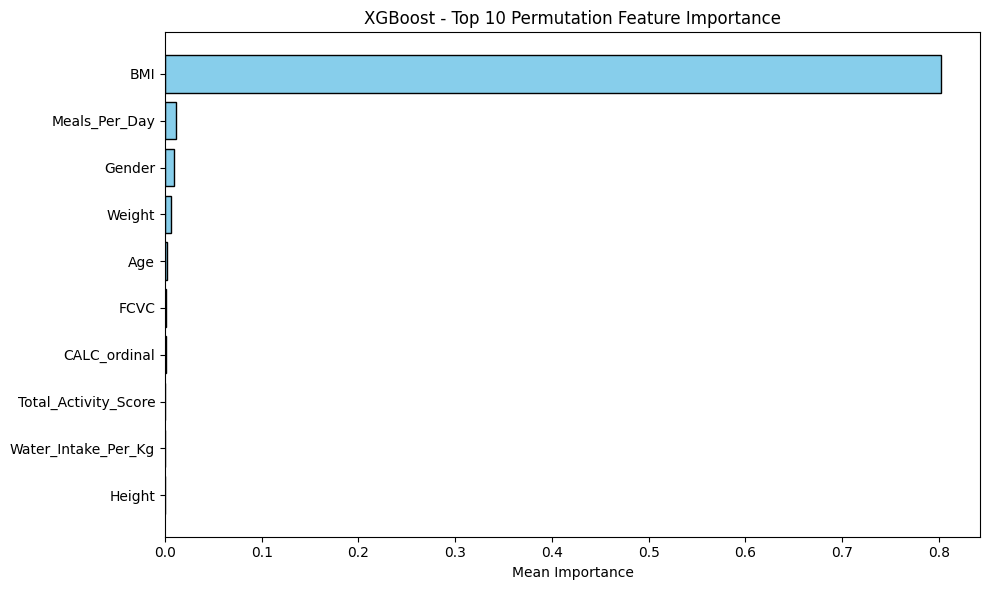

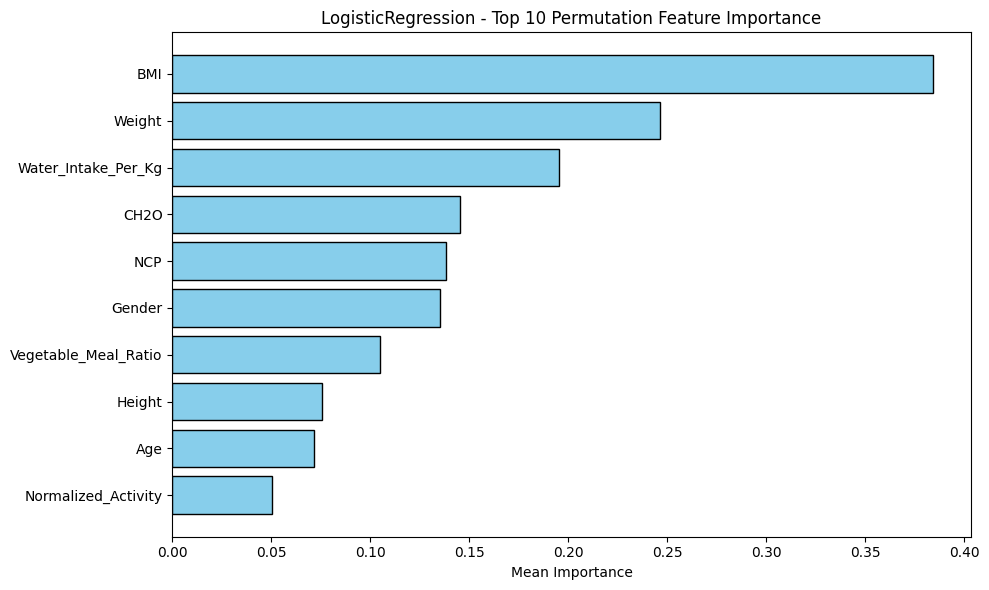

In [36]:
# List of models and their names
models = {
    "RandomForest": rf_model,
    "XGBoost": xgb_model,
    "LogisticRegression": logreg
}

# Initialize an empty list to store results
feature_importances = []

# Loop through each model
for model_name, model in models.items():
    # Compute permutation importance for the model
    importance = permutation_importance(model, X_test, y_test, n_repeats=50, random_state=42)
    
    # Sort features by their importance values
    features = np.array(X.columns)
    sorted_idx = importance.importances_mean.argsort()
    
    # Extract the top 10 features
    top_10_idx = sorted_idx[-10:]
    top_10_features = features[top_10_idx]
    top_10_importances = importance.importances_mean[top_10_idx]
    
    # Add results to the list
    for feature, importance_value in zip(top_10_features, top_10_importances):
        feature_importances.append({
            "Model": model_name,
            "Feature": feature,
            "Importance": importance_value
        })
    
    # Visualization of the top 10 features
    plt.figure(figsize=(10, 6))
    plt.barh(top_10_features, top_10_importances, color='skyblue', edgecolor='black')
    plt.xlabel("Mean Importance")
    plt.title(f"{model_name} - Top 10 Permutation Feature Importance")
    plt.tight_layout()
    plt.show()

# Convert the results to a DataFrame
importance_df = pd.DataFrame(feature_importances)

# Save the results to a CSV file
importance_df.to_csv("permutation_feature_importances.csv", index=False)

## 6.2 Feature Importances

gini


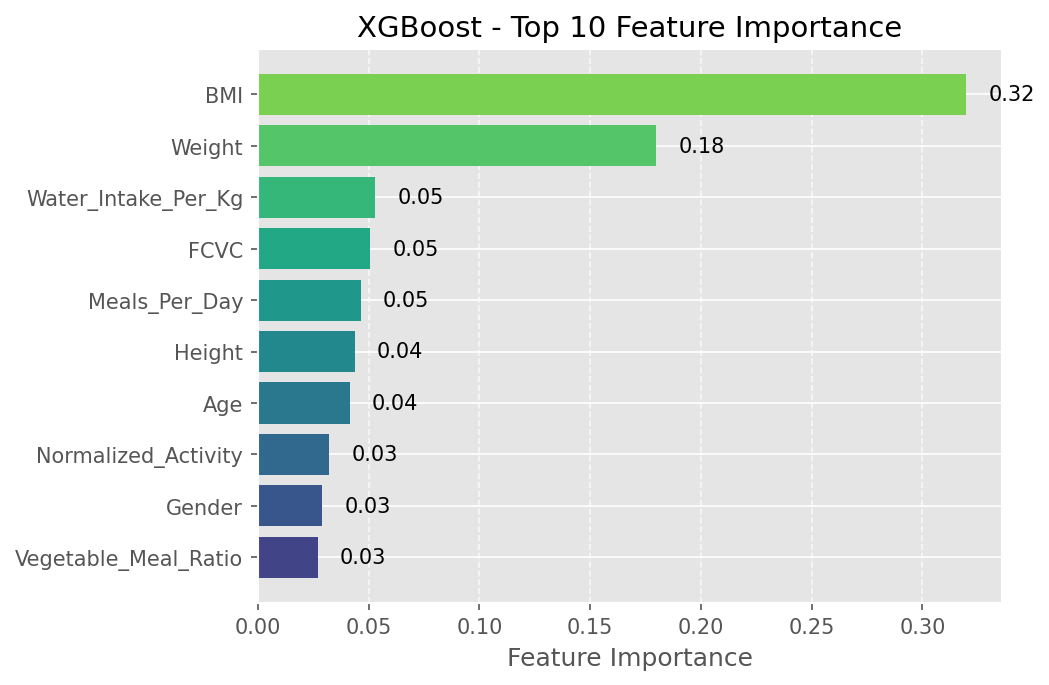

In [37]:
rf_importances = rf_model.feature_importances_

sorted_idx = np.argsort(rf_importances)[-10:]
top_10_features = X.columns[sorted_idx]
top_10_importances = rf_importances[sorted_idx]
print(rf_model.criterion)

plt.style.use('ggplot')
plt.figure(dpi=150)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_10_features)))
plt.barh(top_10_features, top_10_importances, color=colors)
plt.xlabel("Feature Importance", fontsize=12)
plt.title("XGBoost - Top 10 Feature Importance", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(top_10_importances):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=10)

Default feature_importances_: Gain


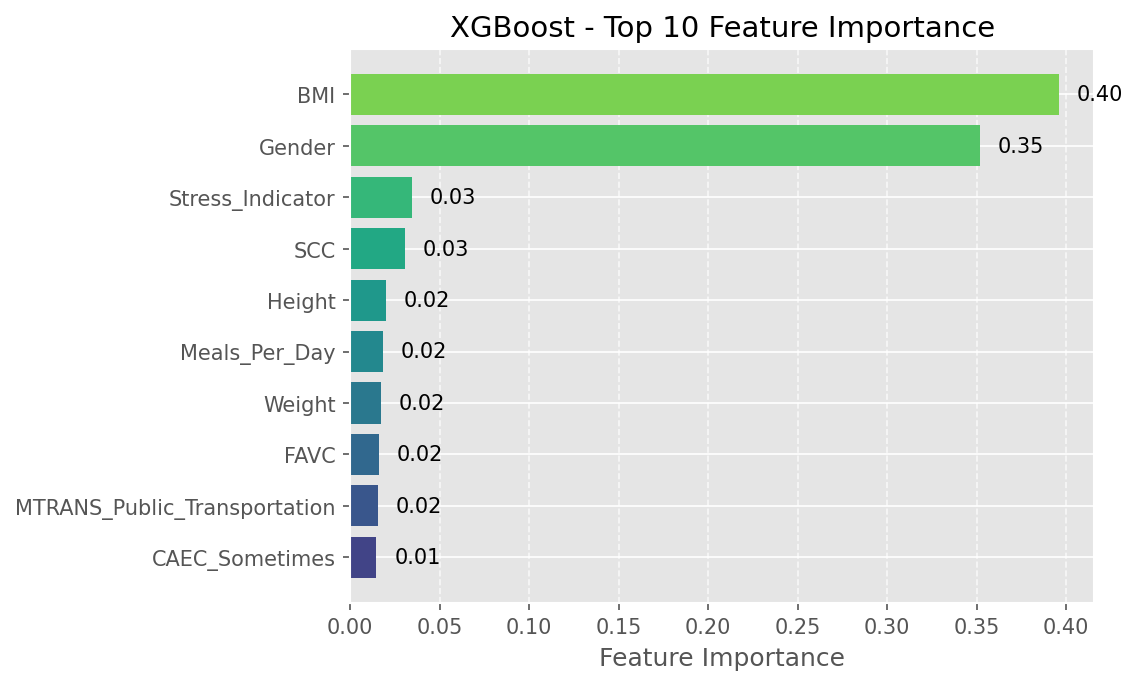

In [38]:
xgb_importances = xgb_model.feature_importances_
print("Default feature_importances_: Gain")

sorted_idx = np.argsort(xgb_importances)[-10:]
top_10_features = X.columns[sorted_idx]
top_10_importances = xgb_importances[sorted_idx]

plt.style.use('ggplot')
plt.figure(dpi=150)

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(top_10_features)))
plt.barh(top_10_features, top_10_importances, color=colors)
plt.xlabel("Feature Importance", fontsize=12)
plt.title("XGBoost - Top 10 Feature Importance", fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

for i, v in enumerate(top_10_importances):
    plt.text(v + 0.01, i, f'{v:.2f}', va='center', fontsize=10)

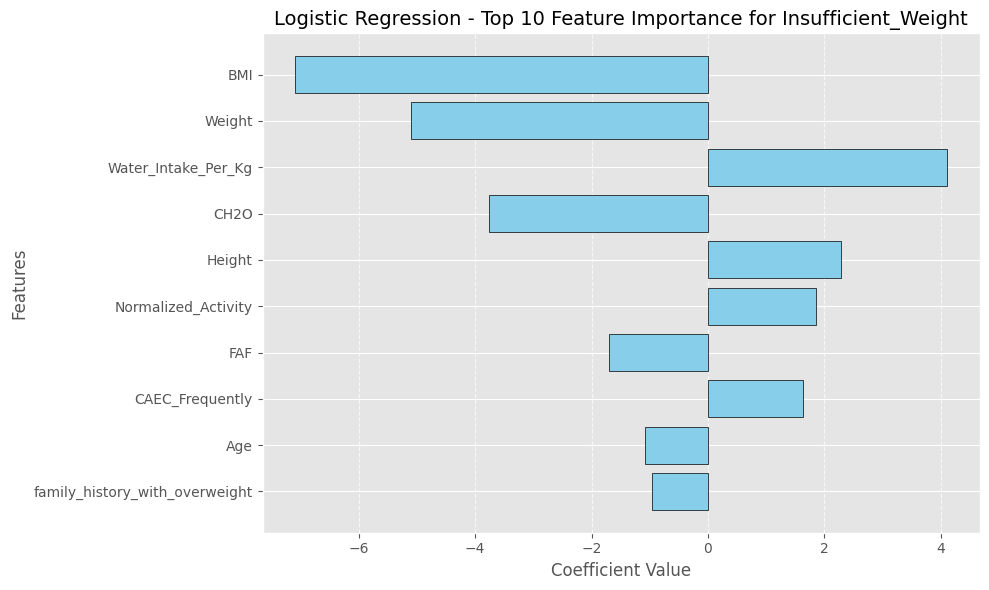

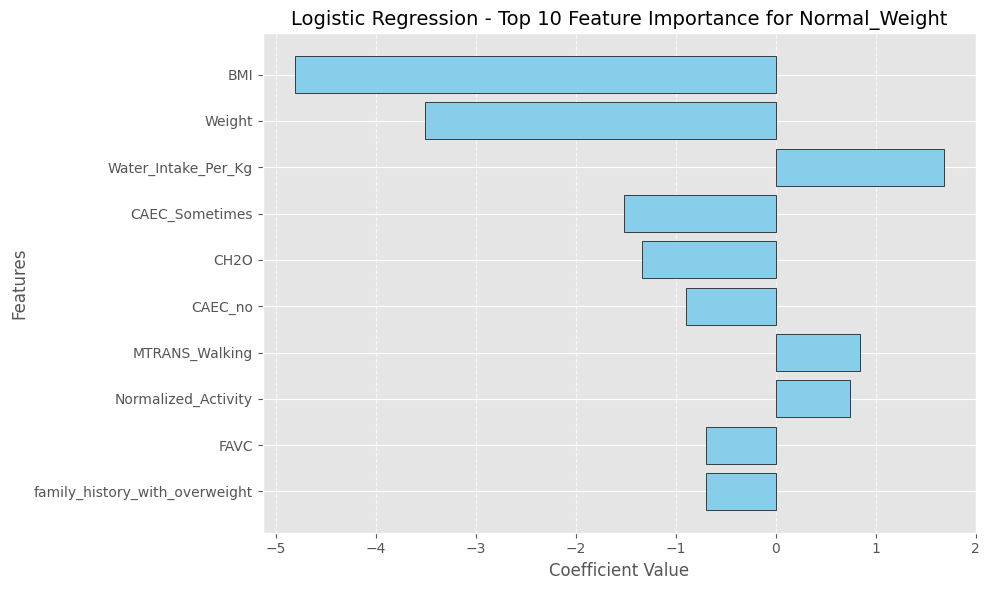

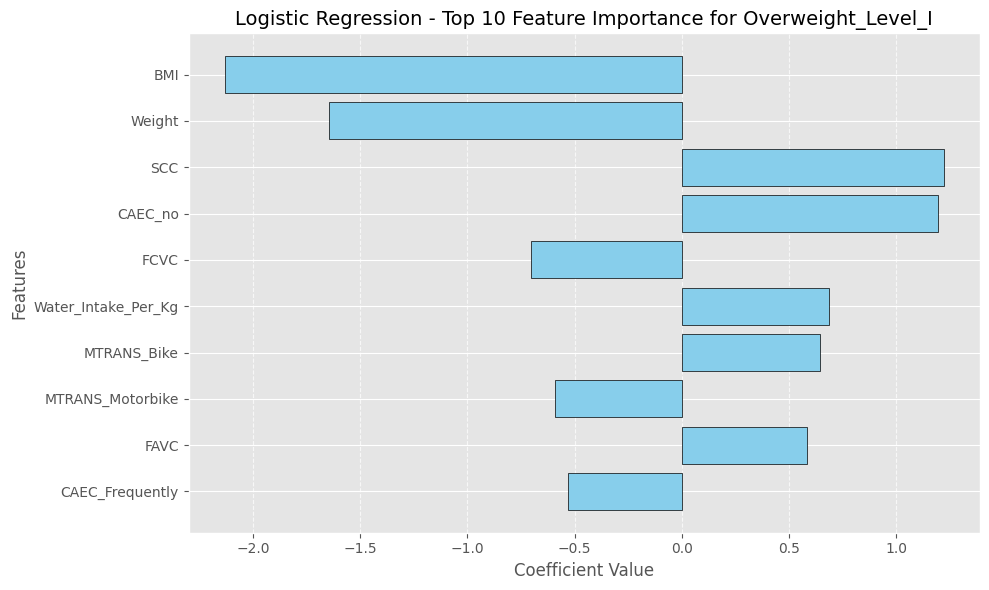

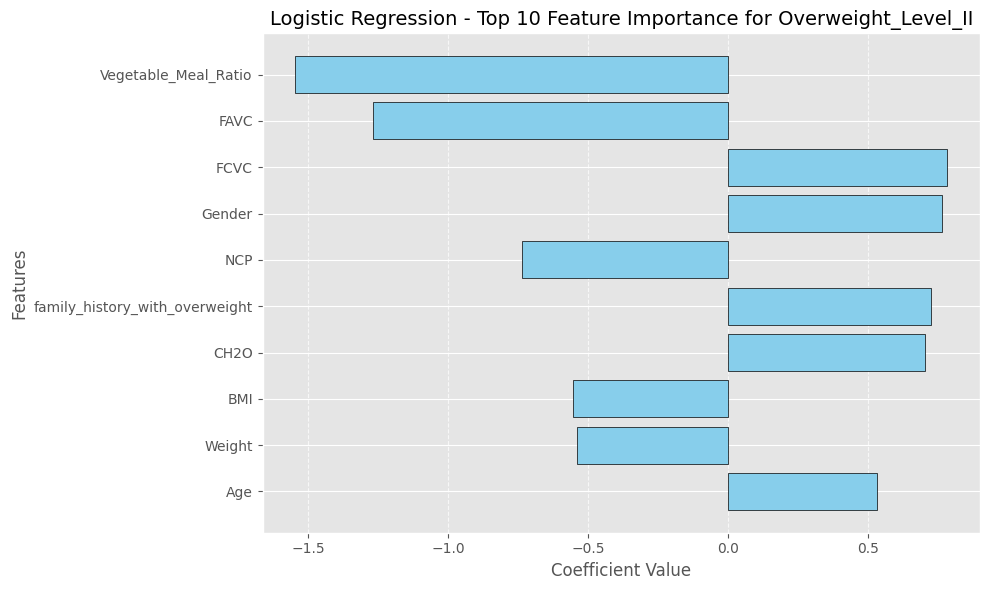

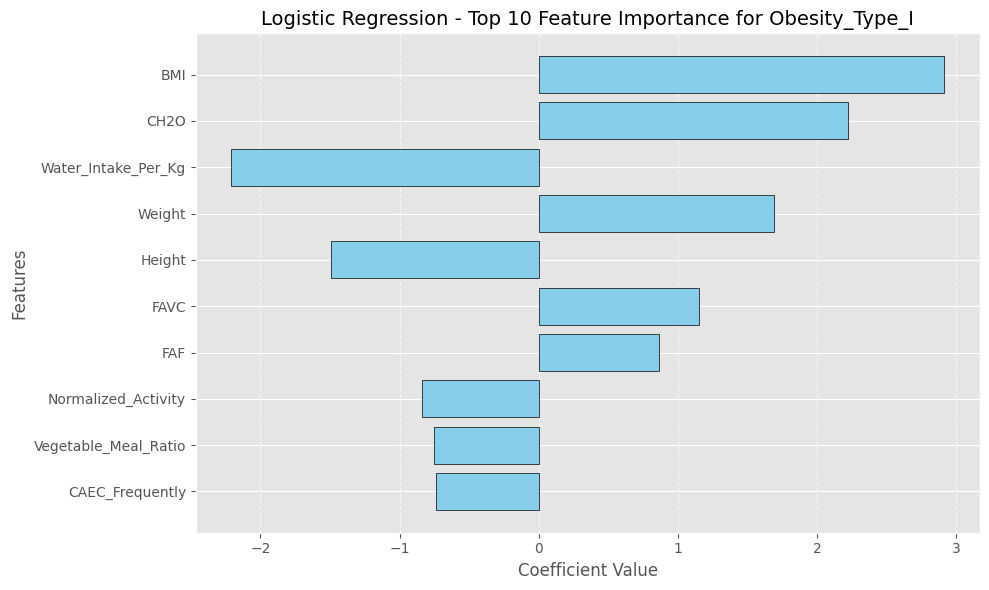

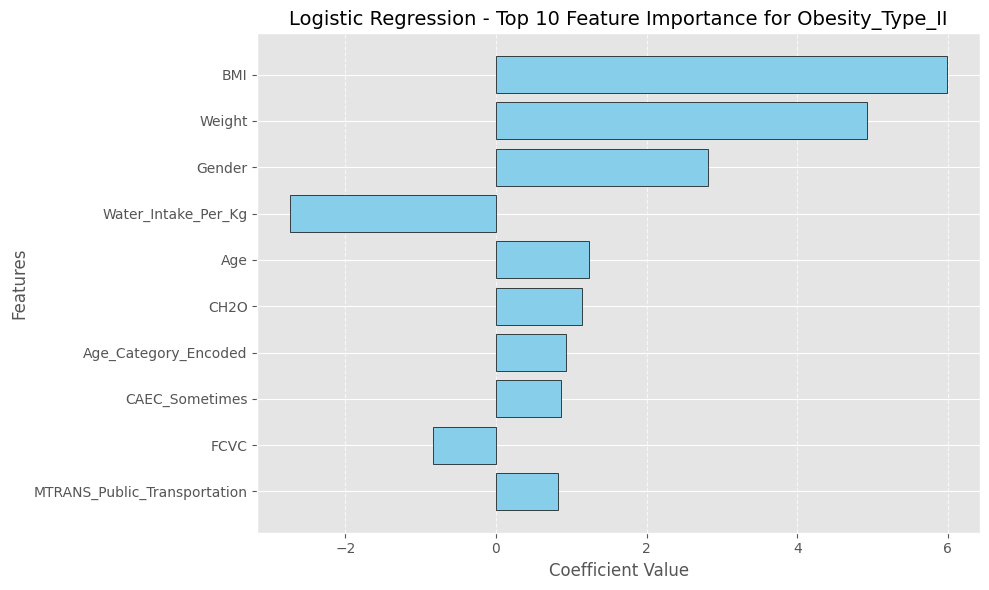

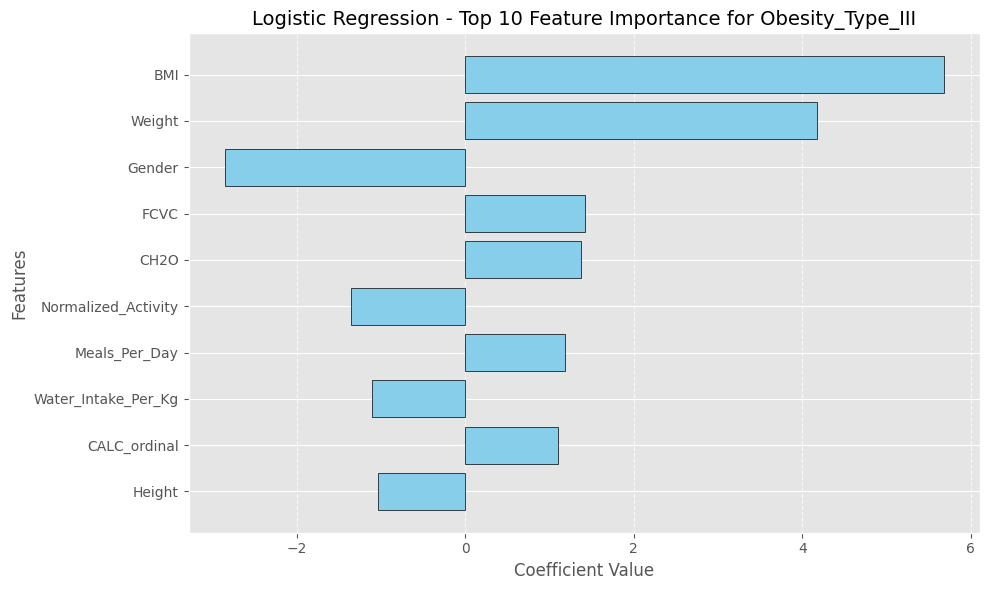

In [39]:
coefficients_data = []

for index, coefficients in enumerate(logreg.coef_):
    features = X.columns
    
    sorted_idx = np.argsort(np.abs(coefficients))[-10:]
    sorted_features = features[sorted_idx]
    sorted_coefficients = coefficients[sorted_idx]
    
    for feature, coef in zip(sorted_features, sorted_coefficients):
        coefficients_data.append({
            "Class": reverse_encoding_obesity_map.get(index),
            "Feature": feature,
            "Coefficient": coef
        })

    plt.figure(figsize=(10, 6))
    plt.barh(sorted_features, sorted_coefficients, color='skyblue', edgecolor='black')
    plt.xlabel("Coefficient Value", fontsize=12)
    plt.ylabel("Features", fontsize=12)
    plt.title(f"Logistic Regression - Top 10 Feature Importance for {reverse_encoding_obesity_map.get(index)}", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

coefficients_df = pd.DataFrame(coefficients_data)

coefficients_df.to_csv("logreg_coefficients.csv", index=False)